In [1]:
import time
import json
from typing import List, Dict, Tuple, Optional
from src.helpers import run_with_mahi_settings, get_open_udp_port
from src.senders import Sender
from src.strategies import SenderStrategy, FixedWindowStrategy, TahoeStrategy, CubicStrategy

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count

from operator import itemgetter

In [3]:
DEFAULT_TIMEOUT = 2
BETA_CUBIC = 0.7

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

Actions = {
    'INCREASE_PERCENT': 0,
    'DECREASE_PERCENT': 1,
    'INCREASE_ABSOLUTE': 2,
    'DECREASE_ABSOLUTE': 3,
    'STAY': 4
}

Rewards = {
    'DROPPED_PACKET': -100,
    'INCREASED_RTT': -40,
    'INCREASED_CWND_ABSOLUTE': 10,
    'INCREASED_CWND_PERCENTAGE': 20,
    'NO_REWARD': 0
}

RTT_AVERAGE_WINDOW = 10

STATE_WINDOW_SIZE = 100

class ReinforcementStrategy(SenderStrategy):
    def __init__(self, slow_start_thresh: int, initial_cwnd: int) -> None:
        self.slow_start_thresh = slow_start_thresh

        self.cwnd = initial_cwnd
        self.fast_retransmit_packet = None
        self.time_since_retransmit = None
        self.retransmitting_packet = False
        self.ack_count = 0
        self.timeout = DEFAULT_TIMEOUT
        self.fast_retransmitted_packets_in_flight = []

        self.duplicated_ack = None
        self.slow_start_thresholds = []
        
        self.next_packet_rewards = {} # Mapping of sequence number to action/state combination

        self.sequence_history_dict = {} # list with some fixed size
        self.transitions = []

        self.rtt_average = None
        super().__init__()

    def window_is_open(self) -> bool:
        # next_ack is the sequence number of the next acknowledgement
        # we are expecting to receive. If the gap between next_ack and
        # seq_num is greater than the window, then we need to wait for
        # more acknowledgements to come in.
        return self.seq_num - self.next_ack < self.cwnd

    def next_packet_to_send(self) -> Optional[str]:
        send_data = None
        in_greater_than_one_retransmit = False
        if self.retransmitting_packet and self.time_of_retransmit and time.time() - self.time_of_retransmit > self.timeout:
            # The retransmit packet timed out--resend it
            self.retransmitting_packet = False
            in_greater_than_one_retransmit = True

        if self.fast_retransmit_packet and not self.retransmitting_packet:
            # Logic for resending the packet
            self.unacknowledged_packets[self.fast_retransmit_packet['seq_num']]['send_ts'] = time.time()
            send_data = self.fast_retransmit_packet
            send_data['is_retransmit'] = True
            serialized_data = json.dumps(send_data)
            self.retransmitting_packet = True
            self.time_of_retransmit = time.time()

        elif self.window_is_open():
            send_data = {
                'seq_num': self.seq_num,
                'send_ts': time.time(),
                'cwnd': self.cwnd,
                'is_retransmit': False
            }

            self.unacknowledged_packets[self.seq_num] = send_data
            self.seq_num += 1
        elif not self.fast_retransmit_packet:
            # Check to see if any segments have timed out. Note that this
            # isn't how TCP actually works--traditional TCP uses exponential
            # backoff for computing the timeouts
            for seq_num, segment in self.unacknowledged_packets.items():
                if seq_num < self.seq_num and time.time() - segment['send_ts'] > self.timeout:
                    segment['send_ts'] = time.time()
                    segment['is_retransmit'] = True
                    self.slow_start_thresh = int(max(1, self.cwnd/2))
                    self.cwnd = 1
                    
                    # Update reinforcement learning based on previous window size increase

                    self.fast_retransmitted_packets_in_flight.append(seq_num)
                    self.fast_retransmit_packet = segment
                    self.sequence_history_dict[seq_num] = {
                        'cwnd': segment['cwnd'],
                        'rtt': 0,
                        'dropped_packet': True
                    }
                    self.update_q_function(seq_num, 0, True)
                    return json.dumps(segment)

        if send_data is None:
            return None
        else:
            return json.dumps(send_data)


    def process_ack(self, serialized_ack: str) -> None:
        ack = json.loads(serialized_ack)
        if ack.get('handshake'):
            return

        self.total_acks += 1
        self.times_of_acknowledgements.append(((time.time() - self.start_time), ack['seq_num']))

        if self.unacknowledged_packets.get(ack['seq_num']) is None:
            # Duplicate ack

            self.num_duplicate_acks += 1
            if self.duplicated_ack and ack['seq_num'] == self.duplicated_ack['seq_num']:
                self.curr_duplicate_acks += 1
            else:
                self.duplicated_ack = ack
                self.curr_duplicate_acks = 1

            if self.curr_duplicate_acks == 3 and (ack['seq_num'] + 1) not in self.fast_retransmitted_packets_in_flight:
                # Received 3 duplicate acks, retransmit
                self.fast_retransmitted_packets_in_flight.append(ack['seq_num'] + 1)
                self.fast_retransmit_packet = self.unacknowledged_packets[ack['seq_num'] + 1]
                self.slow_start_thresh = int(max(1, self.cwnd/2))
                
                self.sequence_history_dict[ack['seq_num']] = {
                    'cwnd': ack['cwnd'],
                    'rtt': 0,
                    'dropped_packet': True
                }
                self.update_q_function(ack['seq_num'], 0, True)
                # Update reinforcement learning based on previous window size increase
                self.cwnd = 1
        elif ack['seq_num'] >= self.next_ack:
            if self.fast_retransmit_packet is not None:
                self.fast_retransmit_packet = None
                self.retransmitting_packet = False
                self.curr_duplicate_acks = 0
                self.seq_num = ack['seq_num'] + 1

                self.fast_retransmitted_packets_in_flight = []

            # Acknowledge all packets where seq_num < ack['seq_num']
            self.unacknowledged_packets = {
                k:v
                for k,v in
                self.unacknowledged_packets.items()
                if k > ack['seq_num']
            }
            self.next_ack = max(self.next_ack, ack['seq_num'] + 1)
            self.seq_num = self.next_ack
            self.ack_count += 1
            self.sent_bytes = ack['ack_bytes']
            rtt = float(time.time() - ack['send_ts'])
            self.rtts.append(rtt)
            self.rtt_recordings.append((time.time(), rtt))

            if self.rtt_average is None:
                self.rtt_average = rtt
            else:
                self.rtt_average = sum(self.rtts[-RTT_AVERAGE_WINDOW:])/len(self.rtts[-RTT_AVERAGE_WINDOW:])
            
            
            self.timeout = rtt * 1.2
            
            self.sequence_history_dict[ack['seq_num']] = {
                'cwnd': ack['cwnd'],
                'rtt': rtt,
                'dropped_packet': False,
                'seq_num': ack['seq_num']
            }
            
            if self.cwnd < self.slow_start_thresh:
                # In slow start
                self.cwnd += 1
            elif (ack['seq_num'] + 1):
                # In congestion avoidance
                self.cwnd += 1.0/self.cwnd
            
            # TODO: Move to other function
            if len(self.unacknowledged_packets.keys()) == 0:
                reward_packet = int(self.cwnd) + ack['seq_num']
                print("NO UNACKNOWLEDGED PACKETS")
            else:
                reward_packet =  (int(self.cwnd) - len(self.unacknowledged_packets)) + max(self.unacknowledged_packets.keys())

            current_action = Actions['INCREASE_PERCENT']
            
            self.next_packet_rewards[reward_packet] = (
                (max(ack['seq_num'] - STATE_WINDOW_SIZE, 0), ack['seq_num']),
                self.rtt_average,
                current_action
            )
            print("reward packet %d" % reward_packet)
            print("getting ack for %d" % ack['seq_num'])
            
            self.update_q_function(ack['seq_num'], rtt)

        self.cwnds.append((time.time(), self.cwnd))
        self.slow_start_thresholds.append((time.time(), self.slow_start_thresh))
    
    def update_q_function(self, seq_num: int, rtt: float = None, dropped_packet: bool = False):
        # Update Q Function
        if self.next_packet_rewards.get(seq_num):
            """In this function, we can now construct state, reward & next state, and add to the Q function"""
            sequence_range, previous_average_rtt, action = self.next_packet_rewards.get(seq_num)

            if dropped_packet:
                rtt = 0
            state = self.compute_state(*sequence_range)
            next_state = self.compute_state(max(seq_num - STATE_WINDOW_SIZE, 0), seq_num)

            reward = self.compute_reward(rtt, previous_average_rtt, action, dropped_packet)

            self.transitions.append(
                Transition(state, action, next_state, reward)
            )

            del self.next_packet_rewards[seq_num]
        
    def compute_state(self, begin: int, end: int) -> List[Dict]:
        return list(zip(*sorted([(seq_num, state)
            for seq_num, state in self.sequence_history_dict.items()
            if seq_num >= begin and seq_num <= end], key=itemgetter(0))))[1]
        
    def compute_reward(self, rtt: float, previous_average_rtt: float, action: int, dropped_packet: bool):
        
        if dropped_packet:
            return Rewards['DROPPED_PACKET']
        
        elif (rtt/previous_average_rtt) > 1.2:
            return Rewards['INCREASED_RTT']
        
        elif action == Actions['INCREASE_PERCENT']:
            return Rewards['INCREASED_CWND_PERCENTAGE']
        elif action == Actions['INCREASE_ABSOLUTE']:
            return Rewards['INCREASED_CWND_ABSOLUTE']
        else:
            return Rewards['NO_REWARD']
        
        
        

[sender] Connected to receiver: 100.64.0.30:48532

NO UNACKNOWLEDGED PACKETS
reward packet 2
getting ack for 0
reward packet 4
getting ack for 1
NO UNACKNOWLEDGED PACKETS
reward packet 6
getting ack for 2
reward packet 8
getting ack for 3
reward packet 10
getting ack for 4
reward packet 12
getting ack for 5
NO UNACKNOWLEDGED PACKETS
reward packet 14
getting ack for 6
reward packet 16
getting ack for 7
reward packet 18
getting ack for 8
reward packet 19
getting ack for 9
reward packet 20
getting ack for 10
reward packet 21
getting ack for 11
reward packet 22
getting ack for 12
reward packet 23
getting ack for 13
NO UNACKNOWLEDGED PACKETS
reward packet 24
getting ack for 14
reward packet 25
getting ack for 15
reward packet 26
getting ack for 16
reward packet 27
getting ack for 17
reward packet 28
getting ack for 18
reward packet 30
getting ack for 19
Transition(state=({'cwnd': 1, 'rtt': 0.30005860328674316, 'dropped_packet': False, 'seq_num': 0}, {'cwnd': 2, 'rtt': 0.29770970344543457, '

reward packet 37
getting ack for 26
reward packet 38
getting ack for 27
Transition(state=({'cwnd': 1, 'rtt': 0.30005860328674316, 'dropped_packet': False, 'seq_num': 0}, {'cwnd': 2, 'rtt': 0.29770970344543457, 'dropped_packet': False, 'seq_num': 1}, {'cwnd': 2, 'rtt': 0.29784488677978516, 'dropped_packet': False, 'seq_num': 2}, {'cwnd': 4, 'rtt': 0.29936742782592773, 'dropped_packet': False, 'seq_num': 3}, {'cwnd': 4, 'rtt': 0.29991865158081055, 'dropped_packet': False, 'seq_num': 4}, {'cwnd': 4, 'rtt': 0.3005836009979248, 'dropped_packet': False, 'seq_num': 5}, {'cwnd': 4, 'rtt': 0.30102968215942383, 'dropped_packet': False, 'seq_num': 6}, {'cwnd': 8, 'rtt': 0.2965514659881592, 'dropped_packet': False, 'seq_num': 7}, {'cwnd': 8, 'rtt': 0.2973325252532959, 'dropped_packet': False, 'seq_num': 8}, {'cwnd': 8, 'rtt': 0.2977468967437744, 'dropped_packet': False, 'seq_num': 9}, {'cwnd': 8, 'rtt': 0.2980344295501709, 'dropped_packet': False, 'seq_num': 10}, {'cwnd': 8, 'rtt': 0.2988235950469

getting ack for 31
Transition(state=({'cwnd': 1, 'rtt': 0.30005860328674316, 'dropped_packet': False, 'seq_num': 0}, {'cwnd': 2, 'rtt': 0.29770970344543457, 'dropped_packet': False, 'seq_num': 1}, {'cwnd': 2, 'rtt': 0.29784488677978516, 'dropped_packet': False, 'seq_num': 2}, {'cwnd': 4, 'rtt': 0.29936742782592773, 'dropped_packet': False, 'seq_num': 3}, {'cwnd': 4, 'rtt': 0.29991865158081055, 'dropped_packet': False, 'seq_num': 4}, {'cwnd': 4, 'rtt': 0.3005836009979248, 'dropped_packet': False, 'seq_num': 5}, {'cwnd': 4, 'rtt': 0.30102968215942383, 'dropped_packet': False, 'seq_num': 6}, {'cwnd': 8, 'rtt': 0.2965514659881592, 'dropped_packet': False, 'seq_num': 7}, {'cwnd': 8, 'rtt': 0.2973325252532959, 'dropped_packet': False, 'seq_num': 8}, {'cwnd': 8, 'rtt': 0.2977468967437744, 'dropped_packet': False, 'seq_num': 9}, {'cwnd': 8, 'rtt': 0.2980344295501709, 'dropped_packet': False, 'seq_num': 10}, {'cwnd': 8, 'rtt': 0.29882359504699707, 'dropped_packet': False, 'seq_num': 11}, {'cwnd

reward packet 51
getting ack for 39
reward packet 52
getting ack for 40
reward packet 53
getting ack for 41
reward packet 54
getting ack for 42
reward packet 56
getting ack for 43
reward packet 57
getting ack for 44
reward packet 58
getting ack for 45
reward packet 59
getting ack for 46
reward packet 60
getting ack for 47
reward packet 61
getting ack for 48
reward packet 62
getting ack for 49
reward packet 63
getting ack for 50
reward packet 64
getting ack for 51
reward packet 65
getting ack for 52
reward packet 66
getting ack for 53
reward packet 67
getting ack for 54
reward packet 68
getting ack for 55
reward packet 70
getting ack for 56
reward packet 71
getting ack for 57
reward packet 72
getting ack for 58
reward packet 73
getting ack for 59
reward packet 74
getting ack for 60
reward packet 75
getting ack for 61
Transition(state=({'cwnd': 1, 'rtt': 0.30005860328674316, 'dropped_packet': False, 'seq_num': 0}, {'cwnd': 2, 'rtt': 0.29770970344543457, 'dropped_packet': False, 'seq_num'

reward packet 80
getting ack for 66
reward packet 81
getting ack for 67
reward packet 82
getting ack for 68
reward packet 83
getting ack for 69
reward packet 84
getting ack for 70
Transition(state=({'cwnd': 1, 'rtt': 0.30005860328674316, 'dropped_packet': False, 'seq_num': 0}, {'cwnd': 2, 'rtt': 0.29770970344543457, 'dropped_packet': False, 'seq_num': 1}, {'cwnd': 2, 'rtt': 0.29784488677978516, 'dropped_packet': False, 'seq_num': 2}, {'cwnd': 4, 'rtt': 0.29936742782592773, 'dropped_packet': False, 'seq_num': 3}, {'cwnd': 4, 'rtt': 0.29991865158081055, 'dropped_packet': False, 'seq_num': 4}, {'cwnd': 4, 'rtt': 0.3005836009979248, 'dropped_packet': False, 'seq_num': 5}, {'cwnd': 4, 'rtt': 0.30102968215942383, 'dropped_packet': False, 'seq_num': 6}, {'cwnd': 8, 'rtt': 0.2965514659881592, 'dropped_packet': False, 'seq_num': 7}, {'cwnd': 8, 'rtt': 0.2973325252532959, 'dropped_packet': False, 'seq_num': 8}, {'cwnd': 8, 'rtt': 0.2977468967437744, 'dropped_packet': False, 'seq_num': 9}, {'cwnd

reward packet 91
getting ack for 76
reward packet 92
getting ack for 77
reward packet 93
getting ack for 78
Transition(state=({'cwnd': 1, 'rtt': 0.30005860328674316, 'dropped_packet': False, 'seq_num': 0}, {'cwnd': 2, 'rtt': 0.29770970344543457, 'dropped_packet': False, 'seq_num': 1}, {'cwnd': 2, 'rtt': 0.29784488677978516, 'dropped_packet': False, 'seq_num': 2}, {'cwnd': 4, 'rtt': 0.29936742782592773, 'dropped_packet': False, 'seq_num': 3}, {'cwnd': 4, 'rtt': 0.29991865158081055, 'dropped_packet': False, 'seq_num': 4}, {'cwnd': 4, 'rtt': 0.3005836009979248, 'dropped_packet': False, 'seq_num': 5}, {'cwnd': 4, 'rtt': 0.30102968215942383, 'dropped_packet': False, 'seq_num': 6}, {'cwnd': 8, 'rtt': 0.2965514659881592, 'dropped_packet': False, 'seq_num': 7}, {'cwnd': 8, 'rtt': 0.2973325252532959, 'dropped_packet': False, 'seq_num': 8}, {'cwnd': 8, 'rtt': 0.2977468967437744, 'dropped_packet': False, 'seq_num': 9}, {'cwnd': 8, 'rtt': 0.2980344295501709, 'dropped_packet': False, 'seq_num': 10}

reward packet 96
getting ack for 81
Transition(state=({'cwnd': 1, 'rtt': 0.30005860328674316, 'dropped_packet': False, 'seq_num': 0}, {'cwnd': 2, 'rtt': 0.29770970344543457, 'dropped_packet': False, 'seq_num': 1}, {'cwnd': 2, 'rtt': 0.29784488677978516, 'dropped_packet': False, 'seq_num': 2}, {'cwnd': 4, 'rtt': 0.29936742782592773, 'dropped_packet': False, 'seq_num': 3}, {'cwnd': 4, 'rtt': 0.29991865158081055, 'dropped_packet': False, 'seq_num': 4}, {'cwnd': 4, 'rtt': 0.3005836009979248, 'dropped_packet': False, 'seq_num': 5}, {'cwnd': 4, 'rtt': 0.30102968215942383, 'dropped_packet': False, 'seq_num': 6}, {'cwnd': 8, 'rtt': 0.2965514659881592, 'dropped_packet': False, 'seq_num': 7}, {'cwnd': 8, 'rtt': 0.2973325252532959, 'dropped_packet': False, 'seq_num': 8}, {'cwnd': 8, 'rtt': 0.2977468967437744, 'dropped_packet': False, 'seq_num': 9}, {'cwnd': 8, 'rtt': 0.2980344295501709, 'dropped_packet': False, 'seq_num': 10}, {'cwnd': 8, 'rtt': 0.29882359504699707, 'dropped_packet': False, 'seq_

Transition(state=({'cwnd': 1, 'rtt': 0.30005860328674316, 'dropped_packet': False, 'seq_num': 0}, {'cwnd': 2, 'rtt': 0.29770970344543457, 'dropped_packet': False, 'seq_num': 1}, {'cwnd': 2, 'rtt': 0.29784488677978516, 'dropped_packet': False, 'seq_num': 2}, {'cwnd': 4, 'rtt': 0.29936742782592773, 'dropped_packet': False, 'seq_num': 3}, {'cwnd': 4, 'rtt': 0.29991865158081055, 'dropped_packet': False, 'seq_num': 4}, {'cwnd': 4, 'rtt': 0.3005836009979248, 'dropped_packet': False, 'seq_num': 5}, {'cwnd': 4, 'rtt': 0.30102968215942383, 'dropped_packet': False, 'seq_num': 6}, {'cwnd': 8, 'rtt': 0.2965514659881592, 'dropped_packet': False, 'seq_num': 7}, {'cwnd': 8, 'rtt': 0.2973325252532959, 'dropped_packet': False, 'seq_num': 8}, {'cwnd': 8, 'rtt': 0.2977468967437744, 'dropped_packet': False, 'seq_num': 9}, {'cwnd': 8, 'rtt': 0.2980344295501709, 'dropped_packet': False, 'seq_num': 10}, {'cwnd': 8, 'rtt': 0.29882359504699707, 'dropped_packet': False, 'seq_num': 11}, {'cwnd': 8, 'rtt': 0.2992

reward packet 110
getting ack for 94
Transition(state=({'cwnd': 1, 'rtt': 0.30005860328674316, 'dropped_packet': False, 'seq_num': 0}, {'cwnd': 2, 'rtt': 0.29770970344543457, 'dropped_packet': False, 'seq_num': 1}, {'cwnd': 2, 'rtt': 0.29784488677978516, 'dropped_packet': False, 'seq_num': 2}, {'cwnd': 4, 'rtt': 0.29936742782592773, 'dropped_packet': False, 'seq_num': 3}, {'cwnd': 4, 'rtt': 0.29991865158081055, 'dropped_packet': False, 'seq_num': 4}, {'cwnd': 4, 'rtt': 0.3005836009979248, 'dropped_packet': False, 'seq_num': 5}, {'cwnd': 4, 'rtt': 0.30102968215942383, 'dropped_packet': False, 'seq_num': 6}, {'cwnd': 8, 'rtt': 0.2965514659881592, 'dropped_packet': False, 'seq_num': 7}, {'cwnd': 8, 'rtt': 0.2973325252532959, 'dropped_packet': False, 'seq_num': 8}, {'cwnd': 8, 'rtt': 0.2977468967437744, 'dropped_packet': False, 'seq_num': 9}, {'cwnd': 8, 'rtt': 0.2980344295501709, 'dropped_packet': False, 'seq_num': 10}, {'cwnd': 8, 'rtt': 0.29882359504699707, 'dropped_packet': False, 'seq

Transition(state=({'cwnd': 1, 'rtt': 0.30005860328674316, 'dropped_packet': False, 'seq_num': 0}, {'cwnd': 2, 'rtt': 0.29770970344543457, 'dropped_packet': False, 'seq_num': 1}, {'cwnd': 2, 'rtt': 0.29784488677978516, 'dropped_packet': False, 'seq_num': 2}, {'cwnd': 4, 'rtt': 0.29936742782592773, 'dropped_packet': False, 'seq_num': 3}, {'cwnd': 4, 'rtt': 0.29991865158081055, 'dropped_packet': False, 'seq_num': 4}, {'cwnd': 4, 'rtt': 0.3005836009979248, 'dropped_packet': False, 'seq_num': 5}, {'cwnd': 4, 'rtt': 0.30102968215942383, 'dropped_packet': False, 'seq_num': 6}, {'cwnd': 8, 'rtt': 0.2965514659881592, 'dropped_packet': False, 'seq_num': 7}, {'cwnd': 8, 'rtt': 0.2973325252532959, 'dropped_packet': False, 'seq_num': 8}, {'cwnd': 8, 'rtt': 0.2977468967437744, 'dropped_packet': False, 'seq_num': 9}, {'cwnd': 8, 'rtt': 0.2980344295501709, 'dropped_packet': False, 'seq_num': 10}, {'cwnd': 8, 'rtt': 0.29882359504699707, 'dropped_packet': False, 'seq_num': 11}, {'cwnd': 8, 'rtt': 0.2992

reward packet 116
getting ack for 100
Transition(state=({'cwnd': 1, 'rtt': 0.30005860328674316, 'dropped_packet': False, 'seq_num': 0}, {'cwnd': 2, 'rtt': 0.29770970344543457, 'dropped_packet': False, 'seq_num': 1}, {'cwnd': 2, 'rtt': 0.29784488677978516, 'dropped_packet': False, 'seq_num': 2}, {'cwnd': 4, 'rtt': 0.29936742782592773, 'dropped_packet': False, 'seq_num': 3}, {'cwnd': 4, 'rtt': 0.29991865158081055, 'dropped_packet': False, 'seq_num': 4}, {'cwnd': 4, 'rtt': 0.3005836009979248, 'dropped_packet': False, 'seq_num': 5}, {'cwnd': 4, 'rtt': 0.30102968215942383, 'dropped_packet': False, 'seq_num': 6}, {'cwnd': 8, 'rtt': 0.2965514659881592, 'dropped_packet': False, 'seq_num': 7}, {'cwnd': 8, 'rtt': 0.2973325252532959, 'dropped_packet': False, 'seq_num': 8}, {'cwnd': 8, 'rtt': 0.2977468967437744, 'dropped_packet': False, 'seq_num': 9}, {'cwnd': 8, 'rtt': 0.2980344295501709, 'dropped_packet': False, 'seq_num': 10}, {'cwnd': 8, 'rtt': 0.29882359504699707, 'dropped_packet': False, 'se

reward packet 145
getting ack for 127
reward packet 146
getting ack for 128
reward packet 147
getting ack for 129
reward packet 148
getting ack for 130
reward packet 149
getting ack for 131
reward packet 150
getting ack for 132
reward packet 151
getting ack for 133
reward packet 152
getting ack for 134
reward packet 153
getting ack for 135
reward packet 154
getting ack for 136
reward packet 155
getting ack for 137
reward packet 156
getting ack for 138
reward packet 158
getting ack for 139
reward packet 159
getting ack for 140
reward packet 160
getting ack for 141
reward packet 161
getting ack for 142
reward packet 162
getting ack for 143
reward packet 163
getting ack for 144
reward packet 164
getting ack for 145
reward packet 165
getting ack for 146
reward packet 166
getting ack for 147
reward packet 167
getting ack for 148
reward packet 168
getting ack for 149
reward packet 169
getting ack for 150
reward packet 170
getting ack for 151
reward packet 171
getting ack for 152
reward packe

reward packet 392
getting ack for 364
reward packet 393
getting ack for 365
reward packet 394
getting ack for 366
reward packet 395
getting ack for 367
reward packet 396
getting ack for 368
reward packet 397
getting ack for 369
reward packet 398
getting ack for 370
reward packet 399
getting ack for 371
reward packet 400
getting ack for 372
reward packet 401
getting ack for 373
reward packet 402
getting ack for 374
reward packet 403
getting ack for 375
reward packet 404
getting ack for 376
reward packet 405
getting ack for 377
reward packet 407
getting ack for 378
reward packet 408
getting ack for 379
reward packet 409
getting ack for 380
reward packet 410
getting ack for 381
reward packet 411
getting ack for 382
reward packet 412
getting ack for 383
reward packet 413
getting ack for 384
reward packet 414
getting ack for 385
reward packet 415
getting ack for 386
reward packet 416
getting ack for 387
reward packet 417
getting ack for 388
reward packet 418
getting ack for 389
reward packe

reward packet 632
getting ack for 597
reward packet 633
getting ack for 598
reward packet 634
getting ack for 599
reward packet 635
getting ack for 600
reward packet 636
getting ack for 601
reward packet 637
getting ack for 602
reward packet 638
getting ack for 603
reward packet 639
getting ack for 604
reward packet 640
getting ack for 605
reward packet 642
getting ack for 606
reward packet 643
getting ack for 607
reward packet 644
getting ack for 608
reward packet 645
getting ack for 609
reward packet 646
getting ack for 610
reward packet 647
getting ack for 611
reward packet 648
getting ack for 612
reward packet 649
getting ack for 613
reward packet 650
getting ack for 614
reward packet 651
getting ack for 615
reward packet 652
getting ack for 616
reward packet 653
getting ack for 617
reward packet 654
getting ack for 618
reward packet 655
getting ack for 619
reward packet 656
getting ack for 620
reward packet 657
getting ack for 621
reward packet 658
getting ack for 622
reward packe

reward packet 861
getting ack for 820
reward packet 862
getting ack for 821
reward packet 863
getting ack for 822
reward packet 864
getting ack for 823
reward packet 865
getting ack for 824
reward packet 866
getting ack for 825
reward packet 867
getting ack for 826
reward packet 868
getting ack for 827
reward packet 869
getting ack for 828
reward packet 870
getting ack for 829
reward packet 871
getting ack for 830
reward packet 872
getting ack for 831
reward packet 873
getting ack for 832
reward packet 874
getting ack for 833
reward packet 875
getting ack for 834
reward packet 876
getting ack for 835
reward packet 877
getting ack for 836
reward packet 878
getting ack for 837
Results for sender 53386, with strategy: ReinforcementStrategy
**Throughput:**                           6704.000000 bytes/s
**Average RTT:**                          243.814053 ms



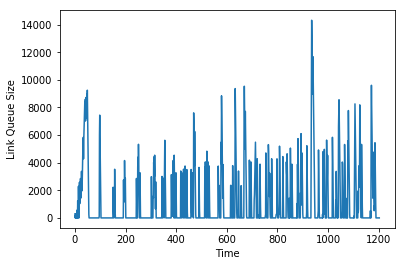

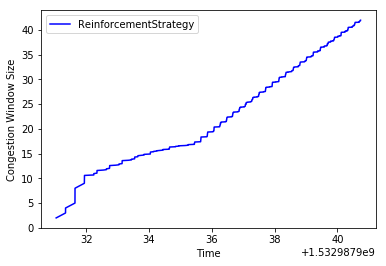

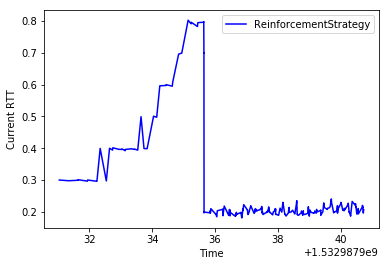

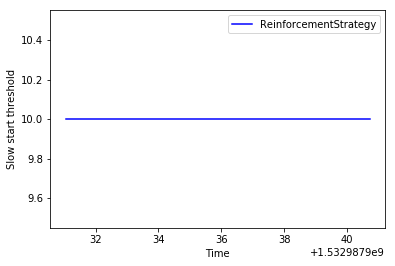

In [4]:
mahimahi_settings = {
    'delay': 88,
    'trace_file': '2.64mbps-poisson.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 30000
    }
}
port = get_open_udp_port()
strat = ReinforcementStrategy(10, 1)
run_with_mahi_settings(mahimahi_settings, 10, [Sender(port, strat)])